# Voice Activity

In [1]:
import os
import librosa
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dropout, Activation, Conv1D, MaxPooling1D, Dense
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)


### Relative Path

In [3]:
cur_path = os.getcwd()

# 1. Read Sample File

In [4]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [5]:
recordNames = ["4CH065I", "4CH066I", "4CH067I", "4CH068I", "4CH069I", "4CH071I", "4CH072I"]
SampleNumbers = {}

In [6]:
recordDatasets = {}
numberOfSamples = []
for recordName in recordNames:
    path_0 = os.path.relpath(f'./ses/{recordName}_Labeled/samples_0', cur_path)
    path_1 = os.path.relpath(f'./ses/{recordName}_Labeled/samples_1', cur_path)
    AudioFiles_0 = [f for f in os.listdir(path_0) if os.path.isfile(os.path.join(path_0, f))]
    AudioFiles_1 = [f for f in os.listdir(path_1) if os.path.isfile(os.path.join(path_1, f))]
    SampleNumbers[recordName] = {
        "Child" : len(AudioFiles_1),
        "NonChild" : len(AudioFiles_0)
    }
    features = []
    labels = []
    for i in range(0, min(len(AudioFiles_0), len(AudioFiles_1))):
        features.append(features_extractor(path_0 + "/" + AudioFiles_0[i]))
        labels.append(0)
        features.append(features_extractor(path_1 + "/" + AudioFiles_1[i]))
        labels.append(1)
    print(f"Dataset: {recordName} Number of Samples: {len(labels)}")
    recordDatasets[f"{recordName}"] = {
        "features" : features,
        "labels" : labels
    }
    numberOfSamples.append(len(labels))


FileNotFoundError: [Errno 2] No such file or directory: 'ses/4CH065I_Labeled/samples_0'

In [9]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## Leave-One-Out Cross-Validation

In [10]:
def plotConfusionMatrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()

def classification_metrics(y_test, y_pred):
    print('accuracy %s' % accuracy_score(y_test, y_pred))
    print('precision score %s' % precision_score(y_test, y_pred))
    print('recall score %s' % recall_score(y_test, y_pred))
    print('f1 score %s' % f1_score(y_test, y_pred))
    plotConfusionMatrix(y_test, y_pred)

In [11]:
def returnModel():
    model = Sequential()
    model.add(Conv1D(256, 5,padding='same',
                    input_shape=(1600,1)))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 5,padding='same',))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same',))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [13]:
LOO_predictions = {}
for testRecordName in recordNames:
    if testRecordName not in recordDatasets:
        continue
    X_test = np.array(recordDatasets[testRecordName]["features"])
    y_test = np.array(recordDatasets[testRecordName]["labels"])
    X_train, y_train = [], []
    for recordName in recordNames:
        if recordName!=testRecordName:
            X_train.extend(recordDatasets[recordName]["features"])
            y_train.extend(recordDatasets[recordName]["labels"])
    X_train = np.array(X_train) 
    y_train = np.array(y_train)
    mm_scaler = preprocessing.MinMaxScaler()
    X_train_minmax = mm_scaler.fit_transform(X_train)
    X_test_minmax = mm_scaler.transform(X_test)
    model = returnModel()
    model.fit(X_train_minmax, y_train, epochs=5, batch_size=32)
    model.save(f"LOO_{testRecordName}")
    print(f"Model is trained for Testing Recod: {testRecordName}")
    y_pred = model.predict(X_test_minmax)
    LOO_predictions[testRecordName] = {
        "y_test" : y_test,
        "y_pred" : (y_pred > 0.5) + 0
    }

Epoch 1/5
181/181 [==============================] - 57s 314ms/step - loss: 0.4456 - accuracy: 0.8079
Epoch 2/5
181/181 [==============================] - 57s 314ms/step - loss: 0.3511 - accuracy: 0.8552
Epoch 3/5
181/181 [==============================] - 56s 311ms/step - loss: 0.3197 - accuracy: 0.8727
Epoch 4/5
181/181 [==============================] - 54s 301ms/step - loss: 0.3038 - accuracy: 0.8806
Epoch 5/5
181/181 [==============================] - 55s 303ms/step - loss: 0.2805 - accuracy: 0.8863


2021-12-31 12:19:24.327728: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: LOO_4CH065I/assets
Model is trained for Testing Recod: 4CH065I
Epoch 1/5
126/126 [==============================] - 38s 296ms/step - loss: 0.5109 - accuracy: 0.7696
Epoch 2/5
126/126 [==============================] - 38s 300ms/step - loss: 0.4142 - accuracy: 0.8214
Epoch 3/5
126/126 [==============================] - 38s 302ms/step - loss: 0.3914 - accuracy: 0.8399
Epoch 4/5
126/126 [==============================] - 38s 302ms/step - loss: 0.3571 - accuracy: 0.8484
Epoch 5/5
126/126 [==============================] - 38s 302ms/step - loss: 0.3498 - accuracy: 0.8554
INFO:tensorflow:Assets written to: LOO_4CH066I/assets
Model is trained for Testing Recod: 4CH066I
Epoch 1/5
183/183 [==============================] - 56s 305ms/step - loss: 0.4198 - accuracy: 0.8212
Epoch 2/5
183/183 [==============================] - 57s 311ms/step - loss: 0.3293 - accuracy: 0.8659
Epoch 3/5
183/183 [==============================] - 56s 306ms/step - loss: 0.2983 - accur

In [14]:
testAcc = []
ChildSampleNumbers, NonChildSampleNumbers = [], []
for record in recordNames:
    acc = accuracy_score(LOO_predictions[record]["y_test"], LOO_predictions[record]["y_pred"])
    testAcc.append(acc)
    ChildSampleNumbers.append(SampleNumbers[record]["Child"])
    NonChildSampleNumbers.append(SampleNumbers[record]["NonChild"])

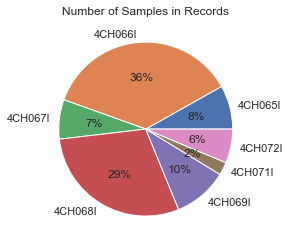

In [15]:
sns.set_theme(style="whitegrid")
plt.pie(numberOfSamples, labels = recordNames, autopct='%.0f%%')
plt.title("Number of Samples in Records")
plt.show()

Text(0.5, 1.0, '4CH072I : Child Non-Child Pie Chart')

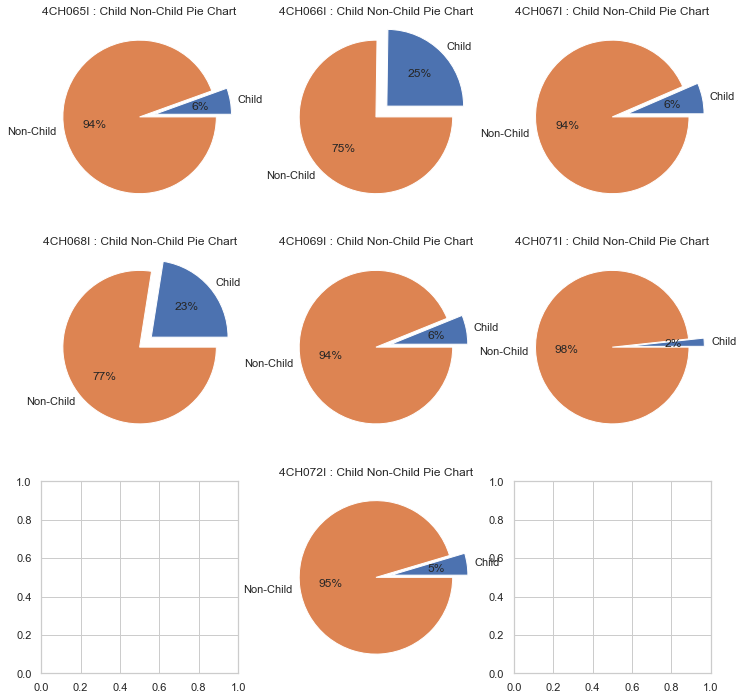

In [16]:
colors = ['#455073','#c0904d']
f, axs = plt.subplots(3,3,figsize=(12,12))
sns.set_theme(style="whitegrid")
myexplode = [0.2, 0]
for i in range(len(recordNames)-1):
    axs[i//3,i%3].pie([ChildSampleNumbers[i], NonChildSampleNumbers[i]], labels = ["Child", "Non-Child"], autopct='%.0f%%', explode = myexplode)
    axs[i//3,i%3].set_title(f"{recordNames[i]} : Child Non-Child Pie Chart")
i = len(recordNames) -1 
axs[(i+1)//3,(i+1)%3].pie([ChildSampleNumbers[i], NonChildSampleNumbers[i]], labels = ["Child", "Non-Child"], autopct='%.0f%%', explode = myexplode)
axs[(i+1)//3,(i+1)%3].set_title(f"{recordNames[i]} : Child Non-Child Pie Chart")

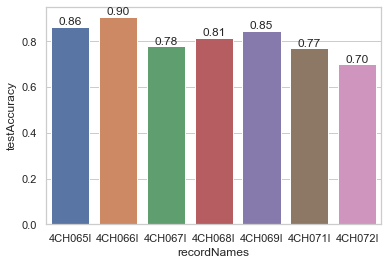

In [17]:
sns.set_theme(style="whitegrid")
df = pd.DataFrame()
df["testAccuracy"] = testAcc
df["recordNames"] = recordNames 
g = sns.barplot(x="recordNames", y="testAccuracy", data=df, ci=None)
show_values(g)

4CH065I
accuracy 0.8735408560311284
precision score 0.8870967741935484
recall score 0.8560311284046692
f1 score 0.8712871287128713


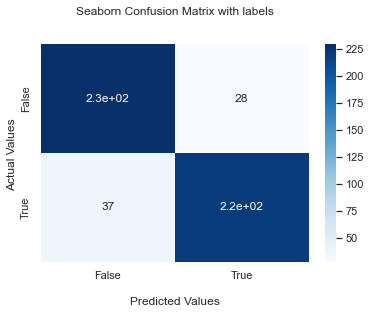

4CH066I
accuracy 0.87521815008726
precision score 0.8380503144654088
recall score 0.9301919720767888
f1 score 0.8817204301075269


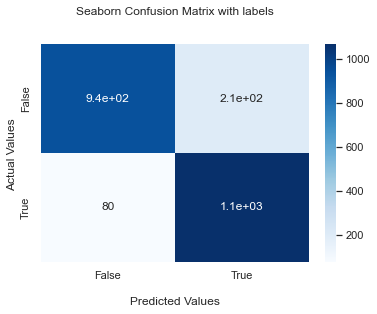

4CH067I
accuracy 0.7380952380952381
precision score 0.7570093457943925
recall score 0.7012987012987013
f1 score 0.7280898876404494


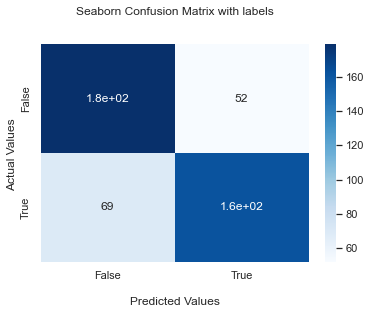

4CH068I
accuracy 0.8154761904761905
precision score 0.8524788391777509
recall score 0.762987012987013
f1 score 0.8052541404911479


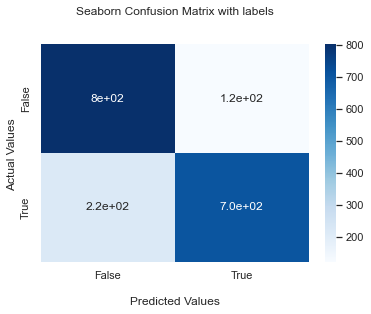

4CH069I
accuracy 0.860062893081761
precision score 0.8961937716262975
recall score 0.8144654088050315
f1 score 0.8533772652388797


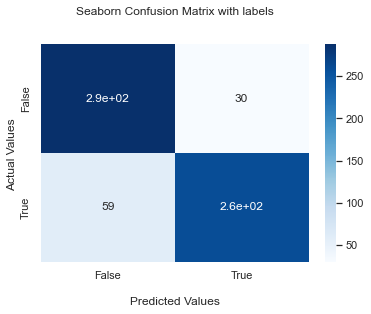

4CH071I
accuracy 0.8223684210526315
precision score 0.8356164383561644
recall score 0.8026315789473685
f1 score 0.8187919463087249


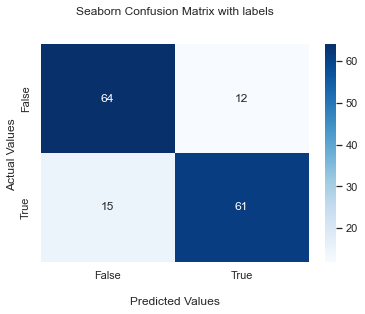

4CH072I
accuracy 0.7386934673366834
precision score 0.8925619834710744
recall score 0.542713567839196
f1 score 0.675


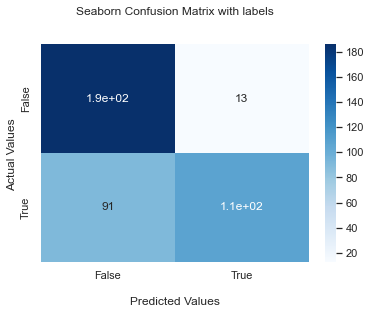

In [49]:
for record in recordNames:                      
    print(record)
    classification_metrics(LOO_predictions[record]["y_test"], LOO_predictions[record]["y_pred"])